In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from torch.utils.data import Dataset, DataLoader

from sklearn.model_selection import KFold, train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, roc_curve, confusion_matrix, classification_report
from tqdm import tqdm

import matplotlib.pyplot as plt
import seaborn as sns

# Checks if a CUDA enabled GPU is available and prints out its information
if torch.cuda.is_available():
    print("CUDA is available!")
    for i in range(torch.cuda.device_count()):
        print(f"GPU {i}: {torch.cuda.get_device_name(i)}")
        
    device = torch.device("cuda:0")

else:
    print("CUDA is not available.")
    device = torch.device("cpu")

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

CUDA is not available.
/kaggle/input/anomaly/amonaly.csv
/kaggle/input/synth-data-outlier/synthetic_trajectories_complete_quantile_outliers.csv
/kaggle/input/synth-data-outlier/synthetic_trajectories_complete_with_outliers_transformed.csv
/kaggle/input/synth-data-outlier/synthetic_trajectories_complete_with_outliers_straight_line.csv
/kaggle/input/synth-data-outlier/synthetic_trajectories_with_outliers.csv
/kaggle/input/synth-data-outlier/synthetic_trajectories_complete_with_outliers.csv


In [2]:
# 1. Data Access & Processing
# ---------------------------------------

# Read data and get basic info
data = pd.read_csv("/kaggle/input/anomaly/amonaly.csv")

# Exclude unneccesary columns 0, 42, and 43
zscore_cols = [col for col in data.columns if '_zscore' in col]
data = data.drop(columns=zscore_cols + ['seq_id_global', 'LabelName', 'Unnamed: 0'], axis=1, errors='ignore')

# Sort by outlier column
data_sorted = data.sort_values('outlier')

# Get total count of inliers (0s)
inliers_count = (data_sorted['outlier'] == 0).sum()

# Calculate split sizes based on total inliers (75%, 12.5%, 12.5%)
train_size = int(0.75 * inliers_count)
val_size = int(0.125 * inliers_count)

# Split remaining inliers and outliers
val_inliers = data_sorted.iloc[train_size:train_size+val_size]
test_inliers = data_sorted.iloc[train_size+val_size:inliers_count]
outliers = data_sorted.iloc[inliers_count:]

# Calculate sizes for balanced val and test sets
total_outliers = len(outliers)
val_outliers_size = total_outliers // 2
test_outliers_size = total_outliers - val_outliers_size

# Create balanced validation and test sets
val_outliers = outliers.iloc[:val_outliers_size]
val_data = pd.concat([val_inliers, val_outliers]).sample(frac=1, random_state=42)
test_outliers = outliers.iloc[val_outliers_size:]
test_data = pd.concat([test_inliers, test_outliers]).sample(frac=1, random_state=43)

# Separate features and labels for validation and testing datasets
val_features = val_data.drop('outlier', axis=1)
val_labels = val_data['outlier']
test_features = test_data.drop('outlier', axis=1)
test_labels = test_data['outlier']

# Convert validation and test data to torch tensors
val_features_tensor = torch.tensor(val_features.values, dtype=torch.float32)
val_labels_tensor = torch.tensor(val_labels.values, dtype=torch.float32)
test_features_tensor = torch.tensor(test_features.values, dtype=torch.float32)
test_labels_tensor = torch.tensor(test_labels.values, dtype=torch.float32)

In [3]:
# 2. Dynamic Training Size Adjustment
# ---------------------------------------

# Define n as the percentage of inliers you want in the training set
n = 1.0  # Example: 50% of the original inliers for the training set

# Recalculate the training size based on n% of the inliers in the training set
train_size_n = int(n * train_size)  # n% of the original train size

# Adjust the training data to use only the first n% of inliers
train_data_n = data_sorted.iloc[:train_size_n]

# Split the new training data into features and labels
train_features_n = train_data_n.drop('outlier', axis=1)
train_labels_n = train_data_n['outlier']

# Convert the new training data to torch tensors
train_tensor_n = torch.tensor(train_features_n.values, dtype=torch.float32)
train_labels_tensor_n = torch.tensor(train_labels_n.values, dtype=torch.float32)

# Print the new training set size for verification
print(f"New Training set size (n% of inliers): {len(train_data_n)}")

New Training set size (n% of inliers): 7529


In [4]:
# 3. Dataset and Dataloader Creation
# ---------------------------------------

# Define the AnomalyDataset class
class AnomalyDataset(Dataset):
    def __init__(self, features, labels=None):
        self.features = features
        self.labels = labels

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        if self.labels is None:
            return self.features[idx], self.features[idx]  # For training (autoencoder)
        return self.features[idx], self.labels[idx]  # For validation and testing

# Create the datasets
train_dataset_n = AnomalyDataset(train_tensor_n)  # No labels for training
val_dataset = AnomalyDataset(val_features_tensor, val_labels_tensor)
test_dataset = AnomalyDataset(test_features_tensor, test_labels_tensor)

# Parameters
batch_size = 64
shuffle = True
input_dim = train_tensor_n.shape[1]

# Create the DataLoaders
train_dataloader = DataLoader(train_dataset_n, batch_size=batch_size, shuffle=shuffle)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=shuffle)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=shuffle)

In [5]:
# 4. Verifying the dataset sizes and label distribution
# -----------------------------------------------------
print(f"Total inliers: {inliers_count}")
print(f"Total Outliers: {total_outliers}")
print(f"Original Training set size: {train_size} (75.0% of inliers)")
print(f"New Training set size (n% of inliers): {len(train_data_n)}")
print(f"Validation set size: {len(val_data)} (inliers: {len(val_inliers)}, outliers: {len(val_outliers)})")
print(f"Test set size: {len(test_data)} (inliers: {len(test_inliers)}, outliers: {len(test_outliers)})")

# Print tensor shapes for final verification
print(train_tensor_n.shape)
print(train_labels_tensor_n.shape)
print(val_features_tensor.shape)
print(val_labels_tensor.shape)
print(test_features_tensor.shape)
print(test_labels_tensor.shape)

# Check distribution of inliers and outliers in new training set
print(f"Inliers in Train Tensor (n%): {sum(1 for label in train_labels_n if label == 0)}")
print(f"Outliers in Train Tensor (n%): {sum(1 for label in train_labels_n if label == 1)}")

# Check distribution of inliers and outliers in validation and test sets
print(f"Inliers in Val Tensor: {sum(1 for label in val_labels_tensor if label == 0)}")
print(f"Outliers in Val Tensor: {sum(1 for label in val_labels_tensor if label == 1)}")
print(f"Inliers in Test Tensor: {sum(1 for label in test_labels_tensor if label == 0)}")
print(f"Outliers in Test Tensor: {sum(1 for label in test_labels_tensor if label == 1)}")
print(f"Total Outliers: {(data_sorted['outlier'] == 1).sum()}")

Total inliers: 10039
Total Outliers: 921
Original Training set size: 7529 (75.0% of inliers)
New Training set size (n% of inliers): 7529
Validation set size: 1714 (inliers: 1254, outliers: 460)
Test set size: 1717 (inliers: 1256, outliers: 461)
torch.Size([7529, 41])
torch.Size([7529])
torch.Size([1714, 41])
torch.Size([1714])
torch.Size([1717, 41])
torch.Size([1717])
Inliers in Train Tensor (n%): 7529
Outliers in Train Tensor (n%): 0
Inliers in Val Tensor: 1254
Outliers in Val Tensor: 460
Inliers in Test Tensor: 1256
Outliers in Test Tensor: 461
Total Outliers: 921


In [6]:
# 5. Model Creation, Definition, and instantiation
# ---------------------------------------

class EnhancedAutoencoderFunctional(nn.Module):
    def __init__(self, input_dim, latent_dim=32, dropout_rate=0.1):
        super(EnhancedAutoencoderFunctional, self).__init__()
        
        # Architecture parameters
        self.input_dim = input_dim
        self.latent_dim = latent_dim
        self.dropout_rate = dropout_rate
        
        # Encoder layers
        self.encoder_fc1 = nn.Linear(input_dim, 128)
        self.encoder_bn1 = nn.BatchNorm1d(128)
        self.encoder_fc2 = nn.Linear(128, 64)
        self.encoder_bn2 = nn.BatchNorm1d(64)
        self.encoder_fc3 = nn.Linear(64, latent_dim)
        self.encoder_bn3 = nn.BatchNorm1d(latent_dim)
        # self.encoder_fc4 = nn.Linear(latent_dim, 16)
        # self.encoder_bn4 = nn.BatchNorm1d(16)

        # # Decoder layers
        # self.decoder_fc4 = nn.Linear(16, latent_dim)
        # self.decoder_bn4 = nn.BatchNorm1d(latent_dim)
        self.decoder_fc1 = nn.Linear(latent_dim, 64)
        self.decoder_bn1 = nn.BatchNorm1d(64)
        self.decoder_fc2 = nn.Linear(64, 128)
        self.decoder_bn2 = nn.BatchNorm1d(128)
        self.decoder_fc3 = nn.Linear(128, input_dim)
        
        # Dropout layer
        self.dropout = nn.Dropout(dropout_rate)

        # Initialize weights
        self.apply(self._init_weights)
        
    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            nn.init.kaiming_normal_(module.weight, mode='fan_in', nonlinearity='leaky_relu')
            if module.bias is not None:
                nn.init.constant_(module.bias, 0)
    
    def encode(self, x):
        # Encoder forward pass
        x = self.encoder_fc1(x)
        x = self.encoder_bn1(x)
        x = F.leaky_relu(x, 0.2)
        x = self.dropout(x)
        
        x = self.encoder_fc2(x)
        x = self.encoder_bn2(x)
        x = F.leaky_relu(x, 0.2)
        x = self.dropout(x)
        
        x = self.encoder_fc3(x)
        x = self.encoder_bn3(x)
        
        return x
    
    def decode(self, x):
        # Decoder forward pass
        x = self.decoder_fc1(x)
        x = self.decoder_bn1(x)
        x = F.leaky_relu(x, 0.2)
        x = self.dropout(x)
        
        x = self.decoder_fc2(x)
        x = self.decoder_bn2(x)
        x = F.leaky_relu(x, 0.2)
        x = self.dropout(x)
        
        x = self.decoder_fc3(x)
        x = torch.tanh(x)  # Output activation
        
        return x
    
    def forward(self, x):
        encoded = self.encode(x)
        decoded = self.decode(encoded)
        return decoded

In [7]:
# 6. Model Instantiation
# ---------------------------------------

def create_model(input_dim, device=device):
    model = EnhancedAutoencoderFunctional(input_dim).to(device)
    
    # Loss function combining MSE and L1 regularization
    criterion = lambda x, y: (
        F.mse_loss(x, y) + 
        0.1 * F.l1_loss(x, y)
    )
    
    # Optimizer with weight decay
    optimizer = optim.AdamW(
        model.parameters(),
        lr=0.001,
        weight_decay=0.01,
        betas=(0.9, 0.999)
    )
    
    # Learning rate scheduler
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(
        optimizer,
        mode='min',
        factor=0.5,
        patience=5,
    )
    
    return model, criterion, optimizer, scheduler

model, criterion, optimizer, scheduler = create_model(input_dim)

Epoch [5/150], Train Loss: 0.2623, Val Loss: 0.4532
Epoch [10/150], Train Loss: 0.2386, Val Loss: 0.4403
Epoch [15/150], Train Loss: 0.2267, Val Loss: 0.4383
Epoch [20/150], Train Loss: 0.2215, Val Loss: 0.4317
Epoch [25/150], Train Loss: 0.2182, Val Loss: 0.4288
Epoch [30/150], Train Loss: 0.2151, Val Loss: 0.4285
Epoch [35/150], Train Loss: 0.2131, Val Loss: 0.4283
Epoch [40/150], Train Loss: 0.2108, Val Loss: 0.4230
Epoch [45/150], Train Loss: 0.2084, Val Loss: 0.4237
Epoch [50/150], Train Loss: 0.2067, Val Loss: 0.4179
Epoch [55/150], Train Loss: 0.2062, Val Loss: 0.4191
Early stopping triggered at epoch 60


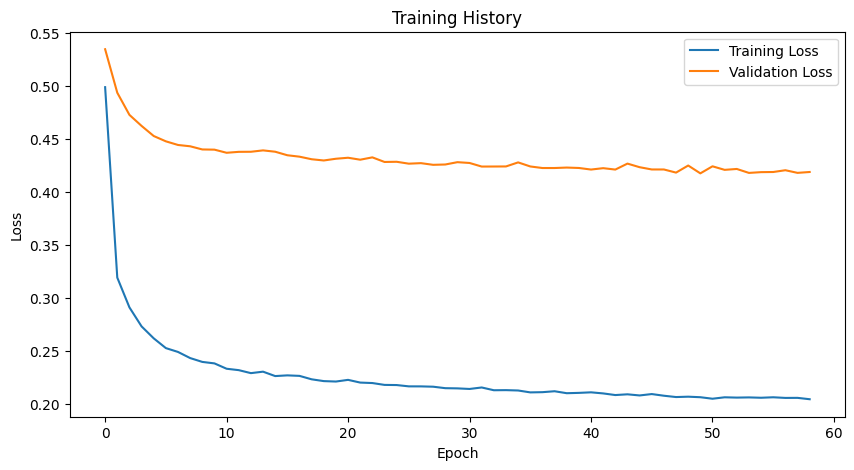

In [8]:
# 7. Model Training
# ---------------------------------------

# Training function with improved monitoring
def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, 
                num_epochs=150, device=device):
    
    best_val_loss = float('inf')
    early_stopping_patience = 10
    early_stopping_counter = 0
    training_history = {'train_loss': [], 'val_loss': []}
    
    for epoch in range(num_epochs):
        # Training phase
        model.train()
        train_loss = 0
        for batch_features, _ in train_loader:
            batch_features = batch_features.to(device)
            
            # Forward pass
            outputs = model(batch_features)
            loss = criterion(outputs, batch_features)
            
            # Backward pass and optimize
            optimizer.zero_grad()
            loss.backward()
            # Gradient clipping
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            
            train_loss += loss.item()
            
        avg_train_loss = train_loss / len(train_loader)
        
        # Validation phase
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for batch_features, _ in val_loader:
                batch_features = batch_features.to(device)
                outputs = model(batch_features)
                loss = criterion(outputs, batch_features)
                val_loss += loss.item()
                
        avg_val_loss = val_loss / len(val_loader)
        
        # Update learning rate
        scheduler.step(avg_val_loss)
        
        # Early stopping check
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            early_stopping_counter = 0
            # Save best model
            torch.save(model.state_dict(), 'best_model.pth')
        else:
            early_stopping_counter += 1
            
        if early_stopping_counter >= early_stopping_patience:
            print(f"Early stopping triggered at epoch {epoch+1}")
            break
            
        # Record history
        training_history['train_loss'].append(avg_train_loss)
        training_history['val_loss'].append(avg_val_loss)
        
        if (epoch + 1) % 5 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], '
                  f'Train Loss: {avg_train_loss:.4f}, '
                  f'Val Loss: {avg_val_loss:.4f}')
            
    return training_history

# Usage
history = train_model(model, train_dataloader, val_dataloader, criterion, optimizer, scheduler)

plt.figure(figsize=(10, 5))
plt.plot(history['train_loss'], label='Training Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training History')
plt.legend()
plt.show()

In [9]:
# 8. Model Evaluation and Metrics
# ---------------------------------------

def evaluate_model(model, dataloader):
    """
    Core evaluation function without visualizations or prints
    """
    errors = []
    labels = []
    reconstructions = []
    original_data = []
    
    model.eval()
    with torch.no_grad():
        for batch_features, batch_labels in dataloader:
            reconstructed = model(batch_features)
            error = torch.mean((batch_features - reconstructed) ** 2, dim=1)
            
            errors.extend(error.numpy())
            labels.extend(batch_labels.numpy())
            reconstructions.extend(reconstructed.numpy())
            original_data.extend(batch_features.numpy())
    
    return {
        'errors': np.array(errors),
        'labels': np.array(labels),
        'reconstructions': np.array(reconstructions),
        'original_data': np.array(original_data)
    }

# Evaluate on validation set and find optimal threshold
print("Computing validation errors...")
val_results = evaluate_model(model, val_dataloader)

# Find optimal threshold
print("\nFinding optimal threshold...")
thresholds = np.percentile(val_results['errors'], np.linspace(0, 100, 100))
best_f1 = 0
optimal_threshold = None

for threshold in thresholds:
    predictions = (val_results['errors'] > threshold).astype(int)
    f1 = f1_score(val_results['labels'], predictions)
    if f1 > best_f1:
        best_f1 = f1
        optimal_threshold = threshold

print(f"\nOptimal threshold found: {optimal_threshold:.6f}")
print(f"Best Validation F1 Score: {best_f1:.4f}")

# Get test results
test_results = evaluate_model(model, test_dataloader)

# Add predictions to results
val_results['predictions'] = (val_results['errors'] > optimal_threshold).astype(int)
test_results['predictions'] = (test_results['errors'] > optimal_threshold).astype(int)

Computing validation errors...

Finding optimal threshold...

Optimal threshold found: 0.218603
Best Validation F1 Score: 0.8065


In [10]:
# 9. Empirical Analysis
# ---------------------------------------

def analyze_results(results, set_name):
    """
    Comprehensive analysis of results
    """
    # Calculate metrics
    precision = precision_score(results['labels'], results['predictions'])
    recall = recall_score(results['labels'], results['predictions'])
    f1 = f1_score(results['labels'], results['predictions'])
    auc_score = roc_auc_score(results['labels'], results['errors'])
    
    print(f"\n{set_name} Set Metrics:")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"AUC-ROC: {auc_score:.4f}")
    
    print(f"\n{set_name} Classification Report:")
    print(classification_report(results['labels'], results['predictions']))
    
    # Misclassification analysis
    misclassified_mask = (results['predictions'] != results['labels'])
    fp_mask = (results['predictions'] == 1) & (results['labels'] == 0)
    fn_mask = (results['predictions'] == 0) & (results['labels'] == 1)
    
    print(f"\n{set_name} Misclassification Analysis:")
    print(f"Total samples: {len(results['labels'])}")
    print(f"Correctly classified: {np.sum(~misclassified_mask)}")
    print(f"Misclassified: {np.sum(misclassified_mask)}")
    print(f"False Positives: {np.sum(fp_mask)}")
    print(f"False Negatives: {np.sum(fn_mask)}")
    
    return precision, recall, f1, auc_score

# Analyze both sets
val_metrics = analyze_results(val_results, "Validation")
test_metrics = analyze_results(test_results, "Test")

# Print side-by-side comparison
print("\nOverall Performance Comparison:")
print("Metric      Validation    Test")
print("-" * 35)
print(f"Precision:  {val_metrics[0]:.4f}       {test_metrics[0]:.4f}")
print(f"Recall:     {val_metrics[1]:.4f}       {test_metrics[1]:.4f}")
print(f"F1-Score:   {val_metrics[2]:.4f}       {test_metrics[2]:.4f}")
print(f"AUC-ROC:    {val_metrics[3]:.4f}       {test_metrics[3]:.4f}")


Validation Set Metrics:
Precision: 0.7182
Recall: 0.9196
F1 Score: 0.8065
AUC-ROC: 0.9546

Validation Classification Report:
              precision    recall  f1-score   support

         0.0       0.97      0.87      0.91      1254
         1.0       0.72      0.92      0.81       460

    accuracy                           0.88      1714
   macro avg       0.84      0.89      0.86      1714
weighted avg       0.90      0.88      0.89      1714


Validation Misclassification Analysis:
Total samples: 1714
Correctly classified: 1511
Misclassified: 203
False Positives: 166
False Negatives: 37

Test Set Metrics:
Precision: 0.6441
Recall: 0.8872
F1 Score: 0.7464
AUC-ROC: 0.9330

Test Classification Report:
              precision    recall  f1-score   support

         0.0       0.95      0.82      0.88      1256
         1.0       0.64      0.89      0.75       461

    accuracy                           0.84      1717
   macro avg       0.80      0.85      0.81      1717
weighted avg  

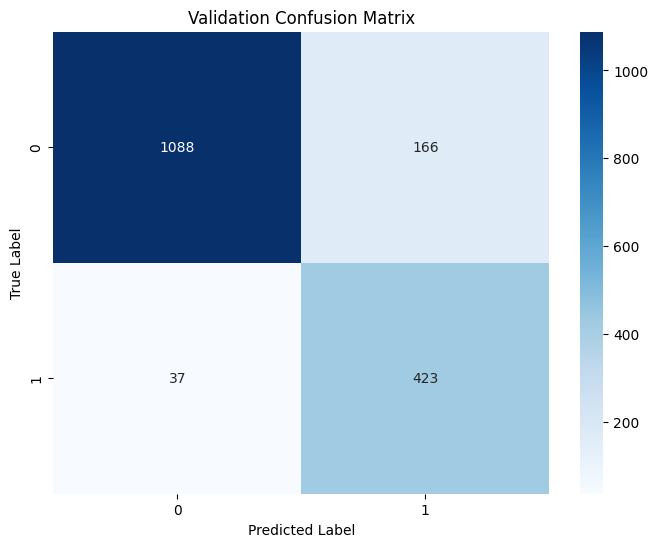

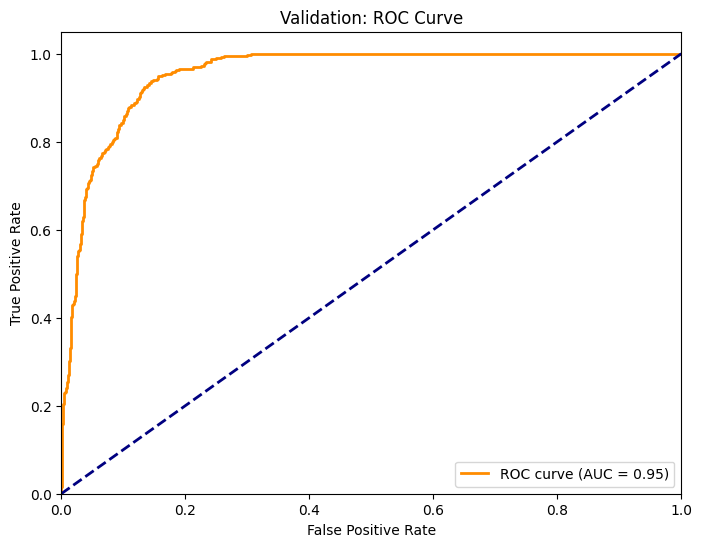

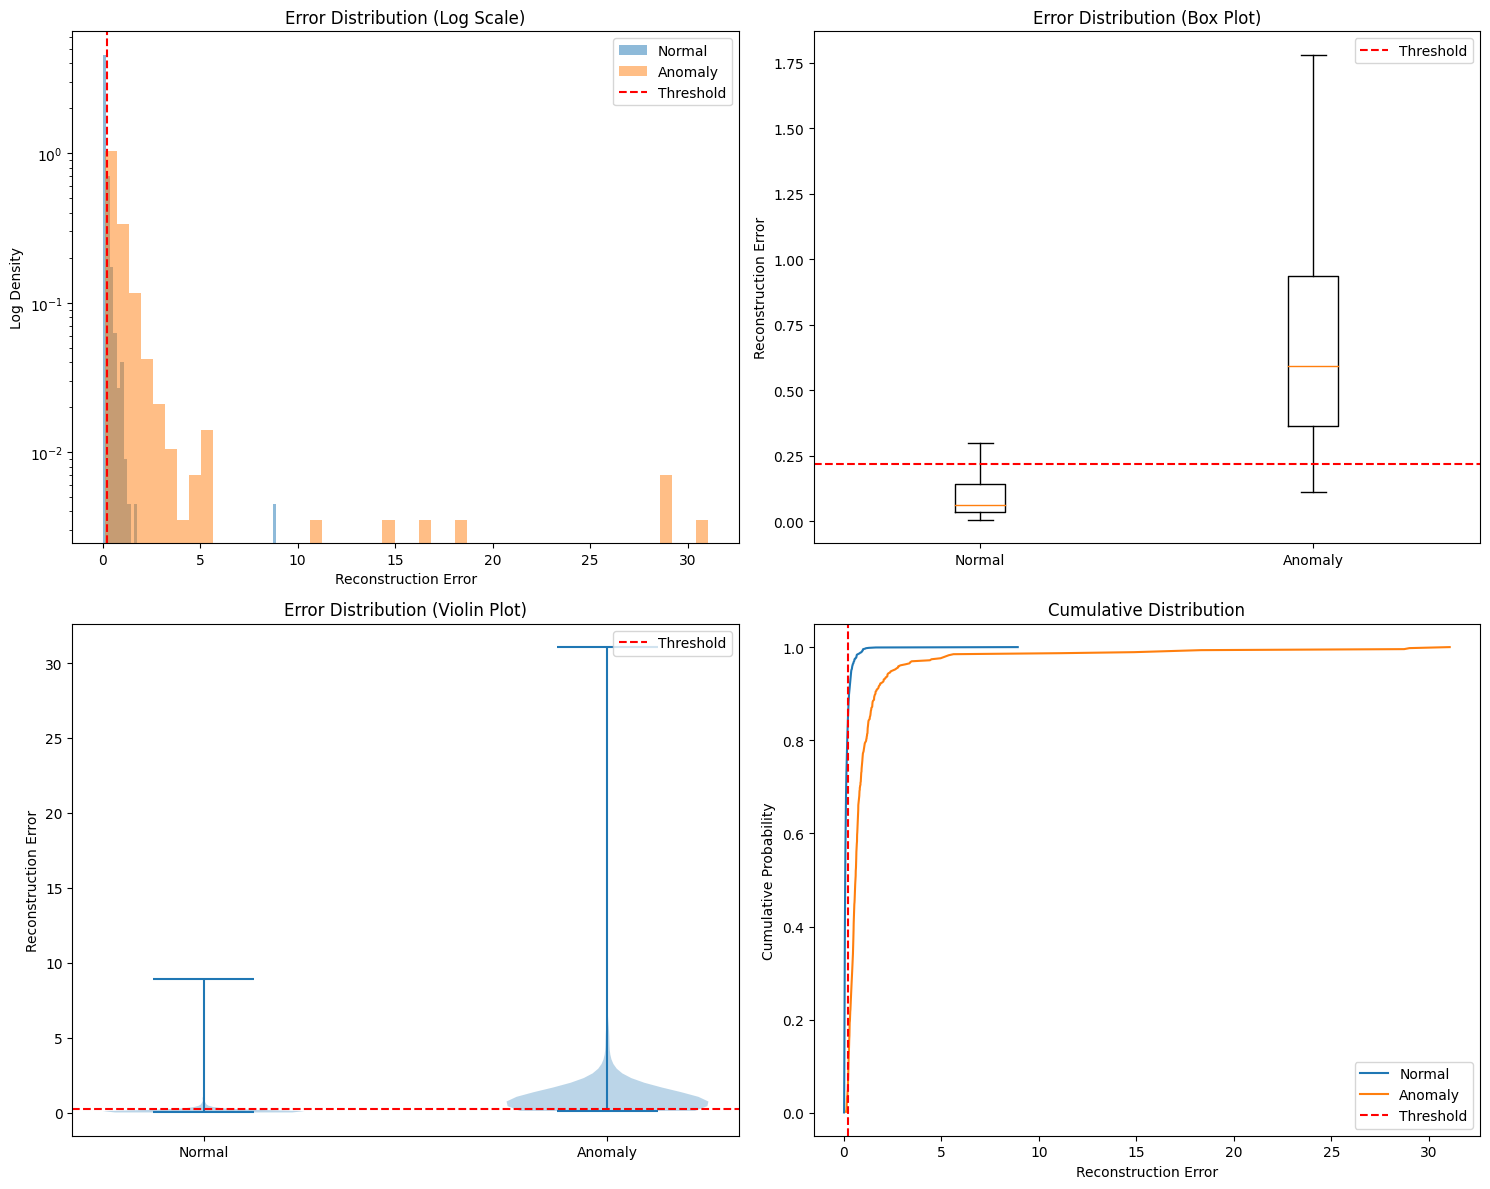

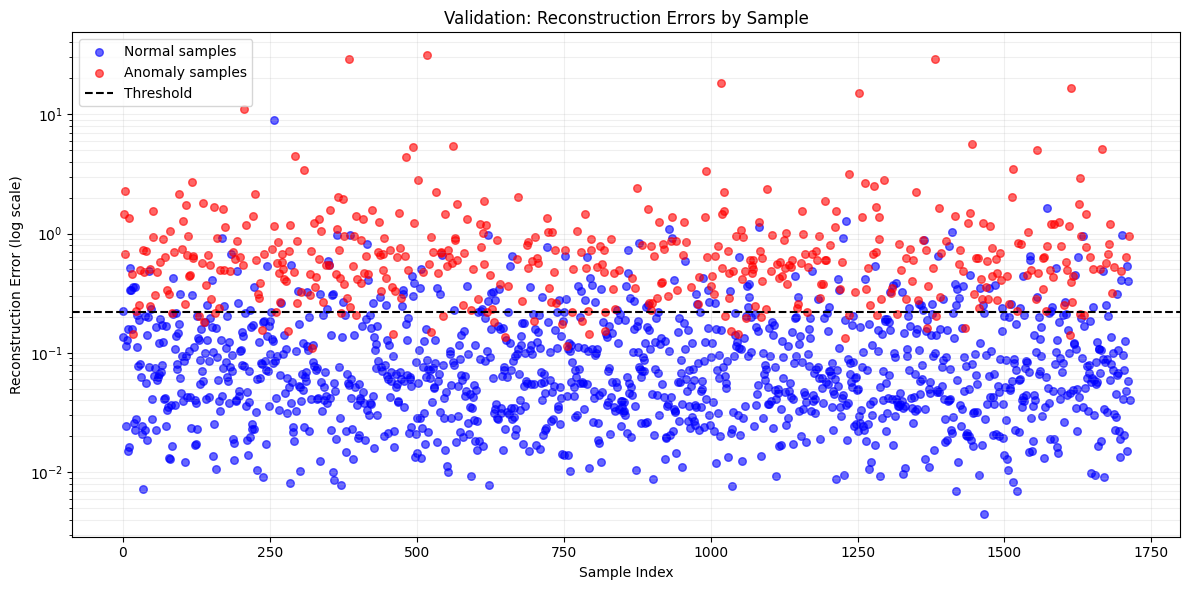

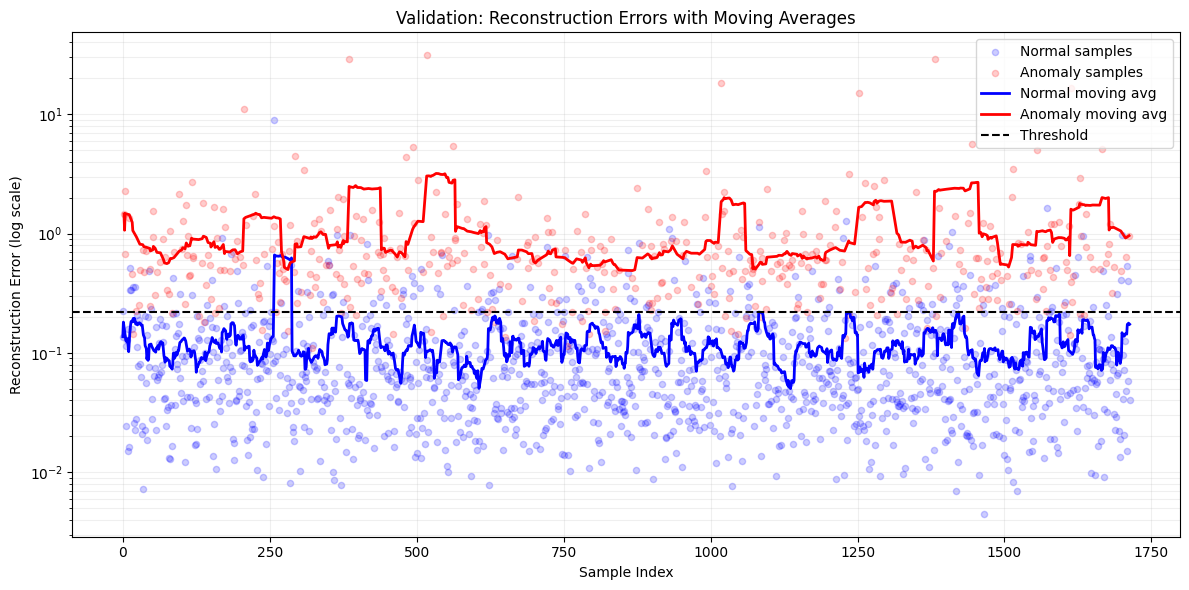

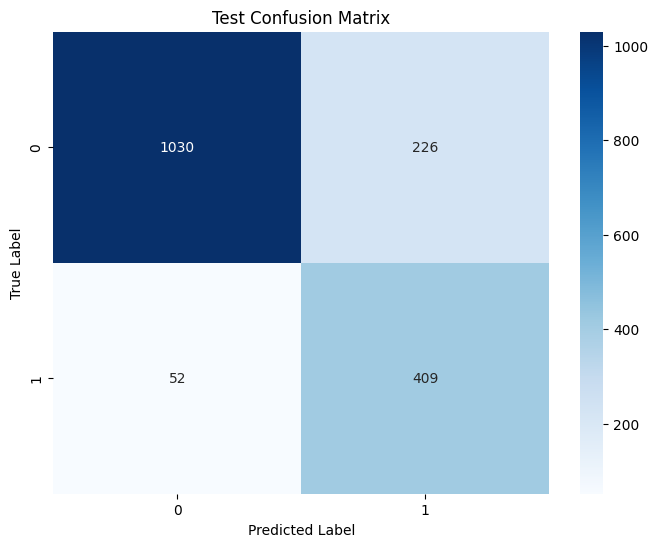

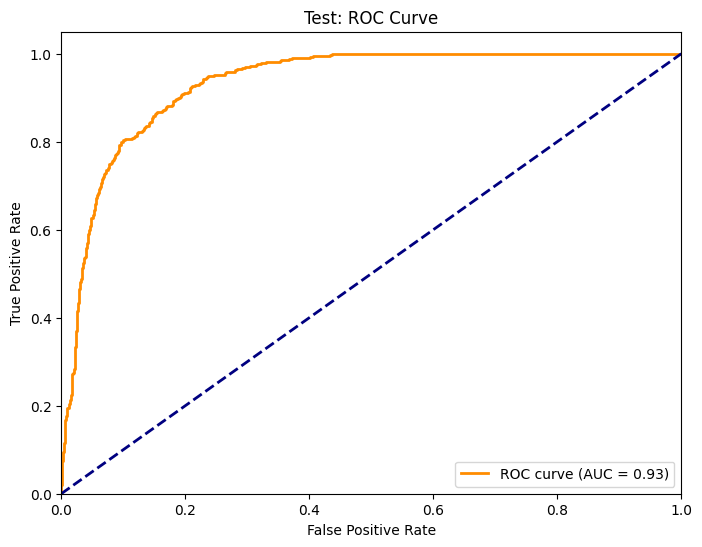

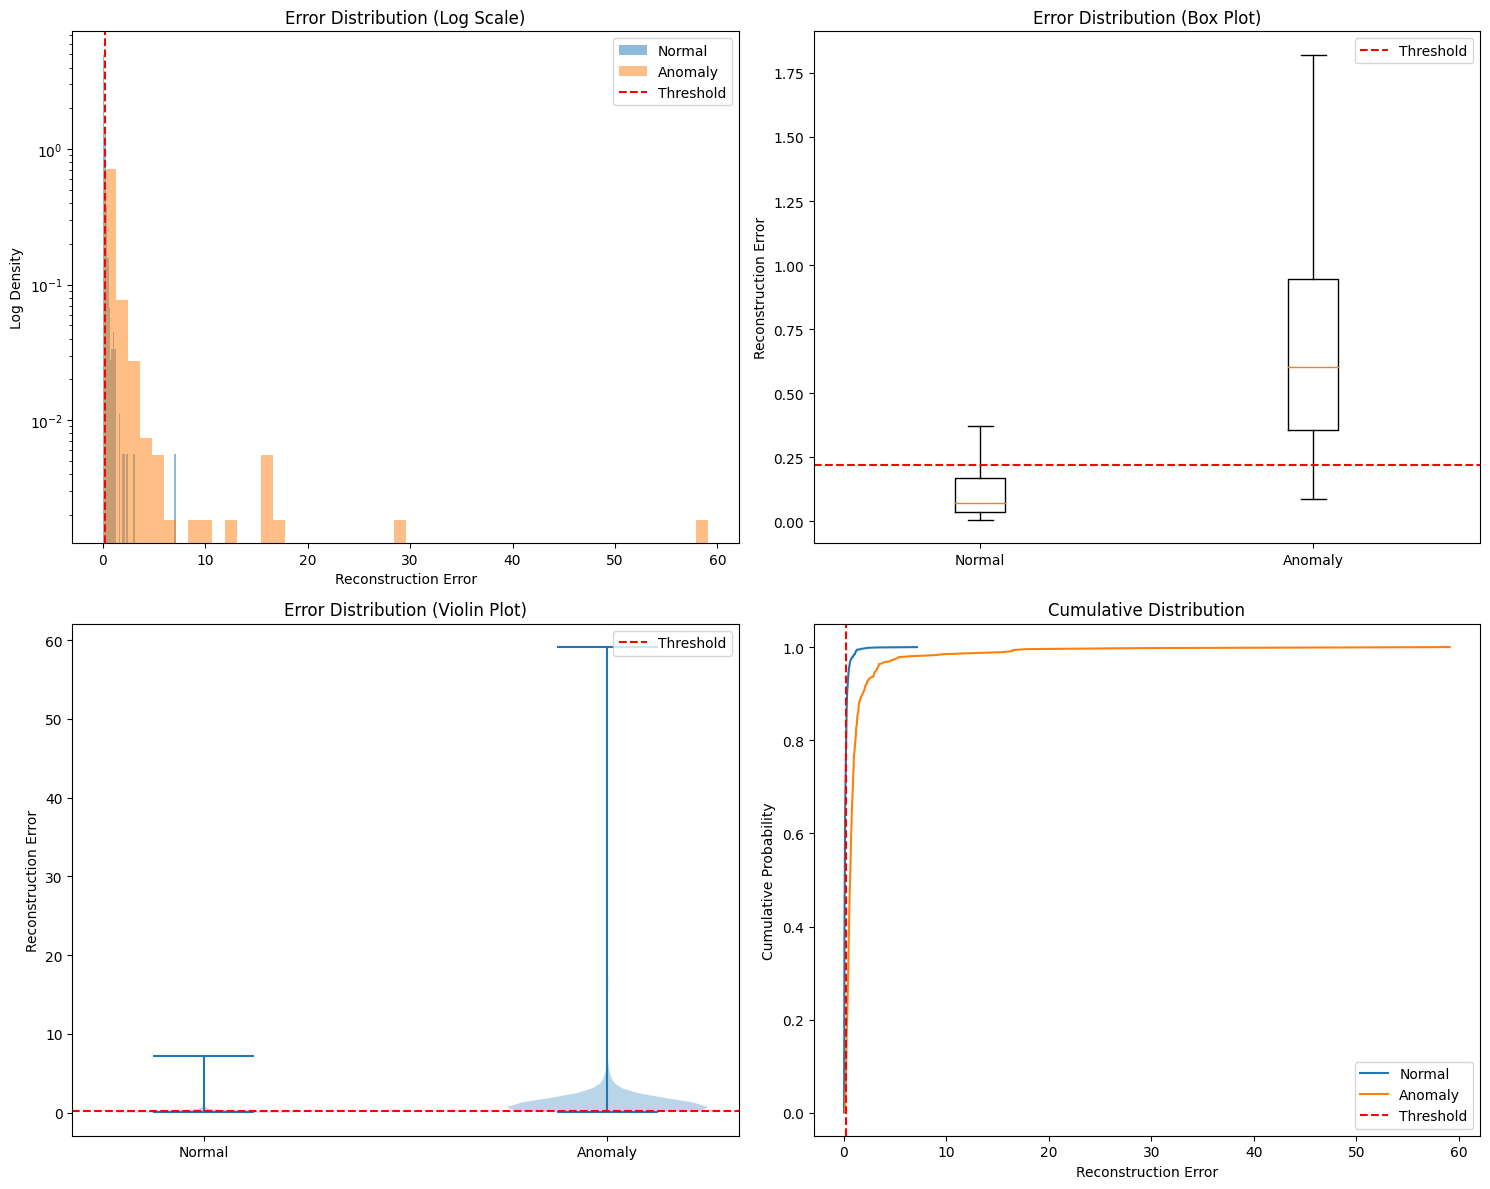

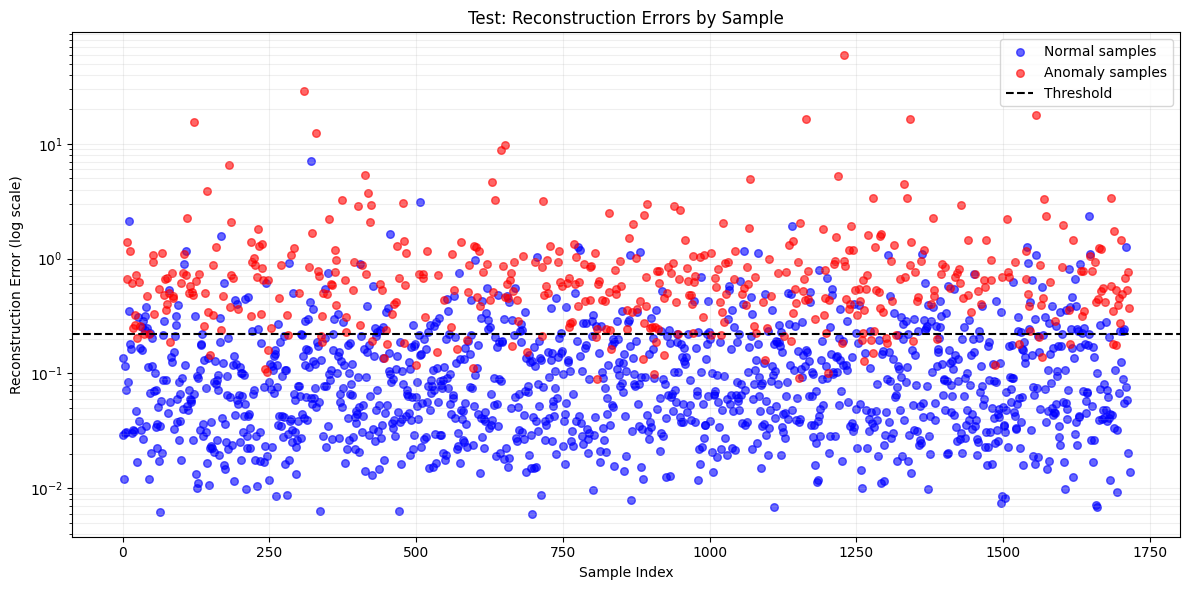

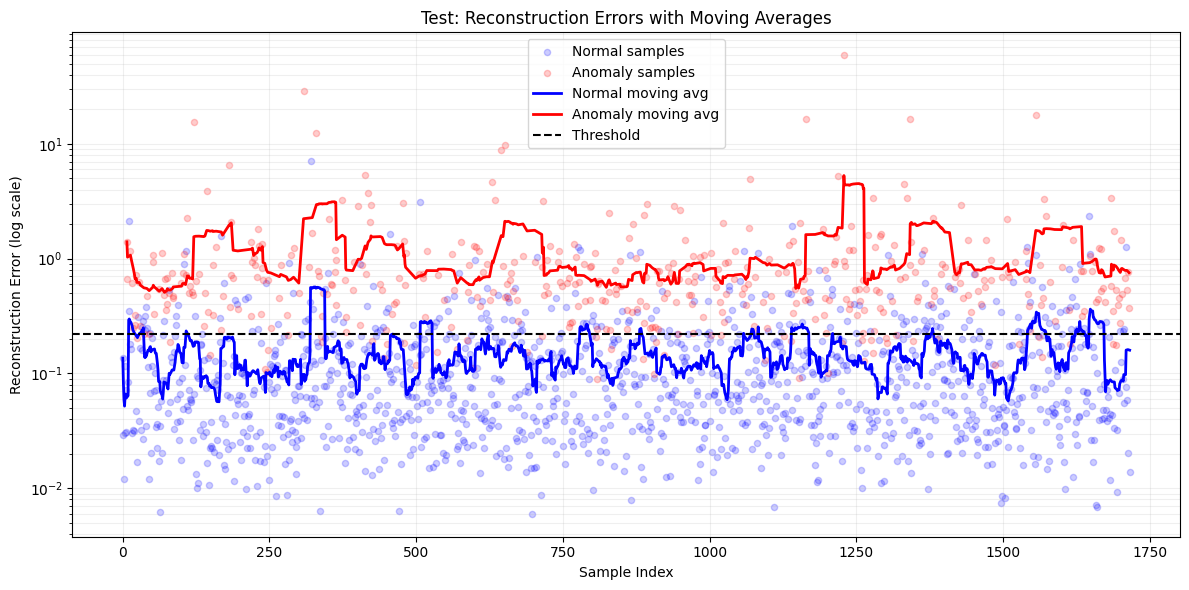

In [11]:
# 10. Visualizations
# ---------------------------------------

def plot_evaluation_visualizations(results, set_name, threshold):
    """
    Generates enhanced evaluation visualizations
    """
    # Confusion Matrix
    cm = confusion_matrix(results['labels'], results['predictions'])
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'{set_name} Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()
    
    # ROC Curve
    fpr, tpr, _ = roc_curve(results['labels'], results['errors'])
    auc_score = roc_auc_score(results['labels'], results['errors'])
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, 
            label=f'ROC curve (AUC = {auc_score:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'{set_name}: ROC Curve')
    plt.legend(loc="lower right")
    plt.show()
    
    # Enhanced Error Distribution Visualizations
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))
    
    # 1. Regular histogram with log scale
    normal_errors = results['errors'][results['labels'] == 0]
    anomaly_errors = results['errors'][results['labels'] == 1]
    
    ax1.hist(normal_errors, bins=50, alpha=0.5, label='Normal', density=True)
    ax1.hist(anomaly_errors, bins=50, alpha=0.5, label='Anomaly', density=True)
    ax1.axvline(x=threshold, color='r', linestyle='--', label='Threshold')
    ax1.set_yscale('log')
    ax1.set_xlabel('Reconstruction Error')
    ax1.set_ylabel('Log Density')
    ax1.set_title('Error Distribution (Log Scale)')
    ax1.legend()
    
    # 2. Box plot comparison
    ax2.boxplot([normal_errors, anomaly_errors], 
                labels=['Normal', 'Anomaly'],
                showfliers=False)  # Optional: hide outliers for better visibility
    ax2.set_ylabel('Reconstruction Error')
    ax2.set_title('Error Distribution (Box Plot)')
    ax2.axhline(y=threshold, color='r', linestyle='--', label='Threshold')
    ax2.legend()
    
    # 3. Violin plot
    ax3.violinplot([normal_errors, anomaly_errors])
    ax3.set_xticks([1, 2])
    ax3.set_xticklabels(['Normal', 'Anomaly'])
    ax3.set_ylabel('Reconstruction Error')
    ax3.set_title('Error Distribution (Violin Plot)')
    ax3.axhline(y=threshold, color='r', linestyle='--', label='Threshold')
    ax3.legend()
    
    # 4. ECDF (Empirical Cumulative Distribution Function)
    def ecdf(data):
        x = np.sort(data)
        y = np.arange(1, len(data) + 1) / len(data)
        return x, y
    
    x_normal, y_normal = ecdf(normal_errors)
    x_anomaly, y_anomaly = ecdf(anomaly_errors)
    
    ax4.plot(x_normal, y_normal, label='Normal')
    ax4.plot(x_anomaly, y_anomaly, label='Anomaly')
    ax4.axvline(x=threshold, color='r', linestyle='--', label='Threshold')
    ax4.set_xlabel('Reconstruction Error')
    ax4.set_ylabel('Cumulative Probability')
    ax4.set_title('Cumulative Distribution')
    ax4.legend()
    
    plt.tight_layout()
    plt.show()
    
    # Enhanced Error scatter plot with threshold and log scale
    plt.figure(figsize=(12, 6))
    
    # Create separate scatter plots for each class for better legend control
    plt.yscale('log')
    plt.scatter(np.where(results['labels'] == 0)[0], 
               results['errors'][results['labels'] == 0] + 1e-10,
               c='blue', alpha=0.6, s=30, label='Normal samples')
    plt.scatter(np.where(results['labels'] == 1)[0], 
               results['errors'][results['labels'] == 1] + 1e-10,
               c='red', alpha=0.6, s=30, label='Anomaly samples')
    
    plt.axhline(y=threshold, color='black', linestyle='--', label='Threshold')
    
    # Customize plot
    plt.xlabel('Sample Index')
    plt.ylabel('Reconstruction Error (log scale)')
    plt.title(f'{set_name}: Reconstruction Errors by Sample')
    
    # Add grid for better readability
    plt.grid(True, which="both", ls="-", alpha=0.2)
    
    # Add legend
    plt.legend()
    
    # Adjust layout
    plt.tight_layout()
    plt.show()
    
    # Optional: Add a second visualization showing error distribution in bins
    plt.figure(figsize=(12, 6))
    
    # Calculate moving average of errors for each class
    window = max(len(results['errors']) // 100, 1)  # Adaptive window size
    
    def moving_average(data, labels, window_size):
        indices = np.arange(len(data))
        normal_mask = labels == 0
        anomaly_mask = labels == 1
        
        # Compute moving averages for each class
        normal_avg = pd.Series(data[normal_mask]).rolling(window_size, min_periods=1).mean()
        anomaly_avg = pd.Series(data[anomaly_mask]).rolling(window_size, min_periods=1).mean()
        
        return (indices[normal_mask], normal_avg, 
                indices[anomaly_mask], anomaly_avg)

    normal_idx, normal_avg, anomaly_idx, anomaly_avg = moving_average(
        results['errors'], results['labels'], window)

    plt.yscale('log')
    plt.scatter(normal_idx, results['errors'][results['labels'] == 0] + 1e-10, 
               c='blue', alpha=0.2, s=20, label='Normal samples')
    plt.scatter(anomaly_idx, results['errors'][results['labels'] == 1] + 1e-10, 
               c='red', alpha=0.2, s=20, label='Anomaly samples')
    
    # Plot moving averages
    plt.plot(normal_idx, normal_avg + 1e-10, 'b-', linewidth=2, 
             label='Normal moving avg')
    plt.plot(anomaly_idx, anomaly_avg + 1e-10, 'r-', linewidth=2, 
             label='Anomaly moving avg')
    
    plt.axhline(y=threshold, color='black', linestyle='--', label='Threshold')
    
    plt.xlabel('Sample Index')
    plt.ylabel('Reconstruction Error (log scale)')
    plt.title(f'{set_name}: Reconstruction Errors with Moving Averages')
    plt.legend()
    plt.grid(True, which="both", ls="-", alpha=0.2)
    plt.tight_layout()
    plt.show()

# Generate visualizations for both sets
plot_evaluation_visualizations(val_results, "Validation", optimal_threshold)
plot_evaluation_visualizations(test_results, "Test", optimal_threshold)

In [12]:
# import warnings
# import torch.optim as optim
# import torch
# import torch.nn.functional as F
# import numpy as np
# import pandas as pd
# import matplotlib.pyplot as plt
# import seaborn as sns
# from sklearn.metrics import (
#     roc_curve, roc_auc_score, 
#     precision_score, recall_score, 
#     f1_score
# )

# class AnomalyScorer:
#     def __init__(self, model):
#         self.model = model
#         self.model.eval()
    
#     def compute_all_scores(self, dataloader):
#         with torch.no_grad():
#             # Initialize lists to store data
#             original_data = []
#             reconstructed_data = []
#             latent_vectors = []
            
#             # Collect data from dataloader
#             device = next(self.model.parameters()).device
#             for batch, _ in dataloader:
#                 batch = batch.to(device)
#                 encoded = self.model.encode(batch)
#                 reconstructed = self.model(batch)
                
#                 original_data.append(batch)
#                 reconstructed_data.append(reconstructed)
#                 latent_vectors.append(encoded)
            
#             # Concatenate batches
#             original_data = torch.cat(original_data, dim=0)
#             reconstructed_data = torch.cat(reconstructed_data, dim=0)
#             latent_vectors = torch.cat(latent_vectors, dim=0)
            
#             # Compute all scores
#             scores = {
#                 'reconstruction_mse': self._compute_reconstruction_mse(original_data, reconstructed_data),
#                 'reconstruction_mae': self._compute_reconstruction_mae(original_data, reconstructed_data),
#                 'latent_norm': self._compute_latent_norm(latent_vectors),
#                 'latent_kl': self._compute_latent_kl(latent_vectors),
#                 'feature_wise': self._compute_feature_wise_errors(original_data, reconstructed_data),
#                 'mahalanobis': self._compute_mahalanobis_score(latent_vectors),
#                 'relative_error': self._compute_relative_error(original_data, reconstructed_data),
#                 'cosine_similarity': self._compute_cosine_similarity(original_data, reconstructed_data)
#             }
            
#             # Compute ensemble score
#             scores['ensemble'] = self._compute_ensemble_score(scores)
            
#             return scores
    
#     def _compute_reconstruction_mse(self, original, reconstructed):
#         """Standard MSE reconstruction error."""
#         return torch.mean((original - reconstructed) ** 2, dim=1).cpu().numpy()
    
#     def _compute_reconstruction_mae(self, original, reconstructed):
#         """MAE reconstruction error."""
#         return torch.mean(torch.abs(original - reconstructed), dim=1).cpu().numpy()
    
#     def _compute_latent_norm(self, latent_vectors):
#         """L2 norm of latent space vectors."""
#         return torch.norm(latent_vectors, p=2, dim=1).cpu().numpy()
    
#     def _compute_latent_kl(self, latent_vectors):
#         """KL divergence using mean and standard deviation."""
#         # Compute KL divergence per sample
#         kl_terms = 0.5 * (latent_vectors.pow(2) - torch.log(latent_vectors.pow(2) + 1e-10) - 1)
#         kl_div = torch.sum(kl_terms, dim=-1)  # Sum over feature dimension
#         return kl_div.cpu().numpy()
    
#     def _compute_feature_wise_errors(self, original, reconstructed):
#         """Feature-wise reconstruction errors weighted by feature importance."""
#         errors = (original - reconstructed) ** 2
#         feature_weights = torch.var(original, dim=0)
#         feature_weights = feature_weights / torch.sum(feature_weights)
#         weighted_errors = errors * feature_weights
#         return torch.sum(weighted_errors, dim=1).cpu().numpy()
    
#     def _compute_mahalanobis_score(self, latent_vectors):
#         """Mahalanobis distance in latent space."""
#         vectors = latent_vectors.cpu().numpy()
#         mean = np.mean(vectors, axis=0)
#         covariance = np.cov(vectors.T)
#         covariance += np.eye(covariance.shape[0]) * 1e-6
#         inv_covariance = np.linalg.inv(covariance)
#         distances = []
#         for vector in vectors:
#             diff = vector - mean
#             dist = np.sqrt(diff.dot(inv_covariance).dot(diff))
#             distances.append(dist)
#         return np.array(distances)
    
#     def _compute_relative_error(self, original, reconstructed):
#         """Relative reconstruction error."""
#         absolute_error = torch.abs(original - reconstructed)
#         relative_error = absolute_error / (torch.abs(original) + 1e-10)
#         return torch.mean(relative_error, dim=1).cpu().numpy()
    
#     def _compute_cosine_similarity(self, original, reconstructed):
#         """Cosine similarity between original and reconstructed data."""
#         similarity = F.cosine_similarity(original, reconstructed)
#         return (1 - similarity).cpu().numpy()
    
#     def _compute_ensemble_score(self, scores):
#         """Compute weighted ensemble of all scores."""
#         normalized_scores = {}
#         for name, score in scores.items():
#             if name != 'ensemble':
#                 min_val = np.min(score)
#                 max_val = np.max(score)
#                 normalized_scores[name] = (score - min_val) / (max_val - min_val + 1e-10)
        
#         weights = {
#             'reconstruction_mse': 0.2,
#             'reconstruction_mae': 0.15,
#             'latent_norm': 0.15,
#             'latent_kl': 0.1,
#             'feature_wise': 0.15,
#             'mahalanobis': 0.1,
#             'relative_error': 0.1,
#             'cosine_similarity': 0.05
#         }
        
#         ensemble_score = np.zeros_like(normalized_scores['reconstruction_mse'])
#         for name, score in normalized_scores.items():
#             ensemble_score += weights[name] * score
        
#         return ensemble_score

# def analyze_anomaly_scores(model, dataloader, labels):
#     """Analyze and compare different anomaly scoring methods."""
#     scorer = AnomalyScorer(model)
#     all_scores = scorer.compute_all_scores(dataloader)
    
#     # Compute ROC-AUC for each scoring method
#     results = {}
#     for method, scores in all_scores.items():
#         auc = roc_auc_score(labels, scores)
#         results[method] = auc
        
#     # Plot ROC curves
#     plt.figure(figsize=(12, 8))
#     for method, scores in all_scores.items():
#         fpr, tpr, _ = roc_curve(labels, scores)
#         plt.plot(fpr, tpr, label=f'{method} (AUC = {results[method]:.3f})')
    
#     plt.plot([0, 1], [0, 1], 'k--')
#     plt.xlabel('False Positive Rate')
#     plt.ylabel('True Positive Rate')
#     plt.title('ROC Curves for Different Anomaly Scoring Methods')
#     plt.legend()
#     plt.show()
    
#     # Plot score distributions
#     fig, axs = plt.subplots(3, 3, figsize=(15, 15))
#     axs = axs.ravel()
    
#     for idx, (method, scores) in enumerate(all_scores.items()):
#         normal_scores = scores[labels == 0]
#         anomaly_scores = scores[labels == 1]
        
#         axs[idx].hist(normal_scores, bins=50, alpha=0.5, label='Normal', density=True)
#         axs[idx].hist(anomaly_scores, bins=50, alpha=0.5, label='Anomaly', density=True)
#         axs[idx].set_title(f'{method}')
#         axs[idx].legend()
    
#     plt.tight_layout()
#     plt.show()
    
#     # Correlation analysis between different scoring methods
#     score_df = pd.DataFrame(all_scores)
#     correlation_matrix = score_df.corr()
    
#     plt.figure(figsize=(10, 8))
#     sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
#     plt.title('Correlation between Different Scoring Methods')
#     plt.show()
    
#     return results

# def threshold_sensitivity_analysis(all_scores, labels):
#     """Analyze how different thresholds affect each scoring method."""
#     results = {}
    
#     for method, scores in all_scores.items():
#         thresholds = np.percentile(scores, np.linspace(0, 100, 100))
#         method_results = []
        
#         for threshold in thresholds:
#             predictions = (scores > threshold).astype(int)
            
#             # Handle zero division cases
#             with warnings.catch_warnings():
#                 warnings.simplefilter("ignore")
#                 f1 = f1_score(labels, predictions, zero_division=0)
#                 precision = precision_score(labels, predictions, zero_division=0)
#                 recall = recall_score(labels, predictions, zero_division=0)
            
#             method_results.append({
#                 'threshold_percentile': threshold,
#                 'f1': f1,
#                 'precision': precision,
#                 'recall': recall
#             })
            
#         results[method] = pd.DataFrame(method_results)
    
#     # Plot threshold sensitivity curves
#     fig, axs = plt.subplots(3, 3, figsize=(15, 15))
#     axs = axs.ravel()
    
#     for idx, (method, df) in enumerate(results.items()):
#         axs[idx].plot(df['threshold_percentile'], df['f1'], label='F1')
#         axs[idx].plot(df['threshold_percentile'], df['precision'], label='Precision')
#         axs[idx].plot(df['threshold_percentile'], df['recall'], label='Recall')
#         axs[idx].set_title(f'{method}')
#         axs[idx].legend()
        
#     plt.tight_layout()
#     plt.show()
    
#     return results

# # Usage example:
# def comprehensive_anomaly_analysis(model, train_loader, test_loader, test_labels):
#     """Run comprehensive analysis of anomaly detection performance."""
#     print("Computing anomaly scores...")
#     scorer = AnomalyScorer(model)
    
#     # Get scores for test set
#     test_scores = scorer.compute_all_scores(test_loader)
    
#     print("\nAnalyzing scoring methods performance...")
#     scoring_performance = analyze_anomaly_scores(model, test_loader, test_labels)
    
#     print("\nAnalyzing threshold sensitivity...")
#     threshold_analysis = threshold_sensitivity_analysis(test_scores, test_labels)
    
#     # Additional analysis: Score stability across different training sizes
#     print("\nAnalyzing score stability across training sizes...")
#     training_sizes = [0.1, 0.5, 1.0]
#     stability_results = {}
    
#     for size in training_sizes:
#         # Create subset of training data
#         subset_loader = subset_data(train_loader, size)
        
#         # Create new model instance with same architecture
#         input_dim = next(iter(subset_loader))[0].shape[1]
#         new_model = EnhancedAutoencoderFunctional(input_dim).to(device)
        
#         # Create optimizer, criterion, and scheduler for new model
#         criterion = lambda x, y: (
#             F.mse_loss(x, y) + 
#             0.1 * F.l1_loss(x, y)
#         )
        
#         optimizer = optim.AdamW(
#             new_model.parameters(),
#             lr=0.001,
#             weight_decay=0.01,
#             betas=(0.9, 0.999)
#         )
        
#         scheduler = optim.lr_scheduler.ReduceLROnPlateau(
#             optimizer,
#             mode='min',
#             factor=0.5,
#             patience=5,
#         )
        
#         # Train the new model
#         train_model(
#             new_model, 
#             subset_loader, 
#             test_loader,  # Using test_loader as validation for consistency
#             criterion, 
#             optimizer, 
#             scheduler,
#             num_epochs=150  # Reduced epochs for stability analysis
#         )
        
#         # Compute scores with trained model
#         scorer_size = AnomalyScorer(new_model)
#         size_scores = scorer_size.compute_all_scores(test_loader)
        
#         stability_results[size] = size_scores
    
#     # Plot score stability
#     methods = list(stability_results[training_sizes[0]].keys())
#     fig, axs = plt.subplots(3, 3, figsize=(15, 15))
#     axs = axs.ravel()
    
#     for idx, method in enumerate(methods):
#         for size in training_sizes:
#             scores = stability_results[size][method]
#             axs[idx].hist(scores, bins=50, alpha=0.3, label=f'Size {size}')
#         axs[idx].set_title(f'{method}')
#         axs[idx].legend()
    
#     plt.tight_layout()
#     plt.show()
    
#     return {
#         'scoring_performance': scoring_performance,
#         'threshold_analysis': threshold_analysis,
#         'stability_results': stability_results
#     }

# # Helper function to create subset of data
# def subset_data(dataloader, fraction):
#     """Create a subset of the dataloader with the given fraction of data."""
#     dataset = dataloader.dataset
#     subset_size = int(len(dataset) * fraction)
#     subset_indices = torch.randperm(len(dataset))[:subset_size]
#     subset = torch.utils.data.Subset(dataset, subset_indices)
#     return torch.utils.data.DataLoader(
#         subset, 
#         batch_size=dataloader.batch_size,
#         shuffle=True
#     )

# # To use the analysis:
# def run_full_analysis(model, train_dataloader, test_dataloader, test_labels_tensor):
#     """
#     Run the complete anomaly detection analysis pipeline.
#     """
#     # Ensure all required imports are present
#     required_imports = [
#         'torch', 'numpy as np', 'pandas as pd', 
#         'matplotlib.pyplot as plt', 'seaborn as sns',
#         'sklearn.metrics'
#     ]
    
#     print("Starting comprehensive anomaly analysis...")
    
#     # Run the analysis
#     results = comprehensive_anomaly_analysis(
#         model=model,
#         train_loader=train_dataloader,
#         test_loader=test_dataloader,
#         test_labels=test_labels_tensor
#     )

#     # Print results for each scoring method
#     for method, auc in results['scoring_performance'].items():
#         print(f"{method:20} AUC: {auc:.4f}")
    
#     # Print detailed results
#     print("\nDetailed Performance Metrics:")
#     print("-" * 50)
#     for method, auc in results['scoring_performance'].items():
#         print(f"{method:20} AUC: {auc:.4f}")
    
#     # Get best performing method
#     best_method = max(results['scoring_performance'].items(), 
#                      key=lambda x: x[1])
#     print(f"\nBest performing method: {best_method[0]} (AUC: {best_method[1]:.4f})")
    
#     # Analyze threshold sensitivity for best method
#     best_method_threshold = results['threshold_analysis'][best_method[0]]
#     best_f1_idx = best_method_threshold['f1'].idxmax()
#     best_threshold = best_method_threshold.loc[best_f1_idx, 'threshold_percentile']
    
#     print(f"\nOptimal threshold for best method: {best_threshold:.4f}")
#     print(f"F1 Score at optimal threshold: {best_method_threshold['f1'].max():.4f}")
    
#     return results

# # Example usage:
# if __name__ == "__main__":
#     # Assuming you have your model and data ready
#     analysis_results = run_full_analysis(
#         model=model,
#         train_dataloader=train_dataloader,
#         test_dataloader=test_dataloader,
#         test_labels_tensor=test_labels_tensor
#     )